# Analysis of Audio Files

## Import Libraries

In [236]:
from google.cloud import speech_v1p1beta1 as speech
from google.cloud import storage

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Conv2D, MaxPooling2D, Dropout, Dense, LSTM, Reshape, Bidirectional
from tensorflow.keras import backend as K

from tqdm import tqdm 

import IPython.display as ipd

import librosa
import librosa.display
from librosa import feature

import soundfile as sf

import string
import json 
import re

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/ekin/Downloads/hack.json"

## Preliminary Experimentation

* Using my own audio to view a waveform

In [46]:
'''
This function reads in a .wav file. 

Set cloud to true if data file path is from the cloud.
'''
def read_wav(file_name, cloud=True):
    # read a blob
    
    if cloud: 
        blob = bucket.blob(file_name)
        file_as_string = blob.download_as_string()

        # convert the string to bytes and then finally to audio samples as floats 
        # and the audio sample rate
        data, sample_rate = sf.read(io.BytesIO(file_as_string))
    else: 
        data, sample_rate = librosa.load(file_name)

    # print(len(data.shape))
    if len(data.shape) == 1: 
        left_channel = data[:]  # I assume the left channel is column zero
    elif len(data.shape) == 2: 
        left_channel = data[:, 0]  # I assume the left channel is column zero

    # enable play button in datalab notebook
    aud = ipd.Audio(left_channel, rate=sample_rate)
    return aud, data, sample_rate

In [47]:
BUCKET = 'hack_the_ne'

# Create a Cloud Storage client.
gcs = storage.Client()

# Get the bucket that the file will be uploaded to.
bucket = gcs.get_bucket(BUCKET)

# specify a filename
# file_name = '2021-01-16T13:35:23.904Z.wav'
data_file_name = 'audio/Actor_01/03-01-01-01-01-01-01.wav'
example_file_name = 'example_1.wav'

In [48]:
aud, data, sample_rate = read_wav(example_file_name)

In [49]:
aud

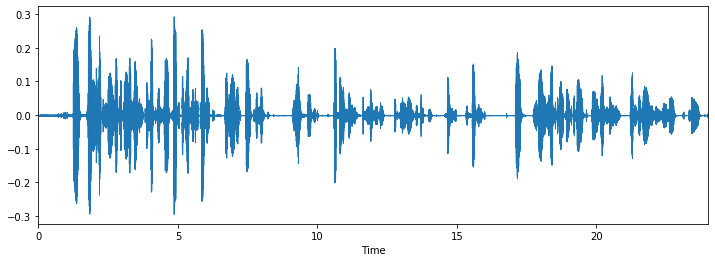

In [50]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data[:, 0], sr=sample_rate)

In [70]:
'''
Test on actor dataset.
'''
# _, actor_data, actor_sample_rate = read_wav(data_file_name, cloud=False)
data, sample_rate = librosa.load(data_file_name)

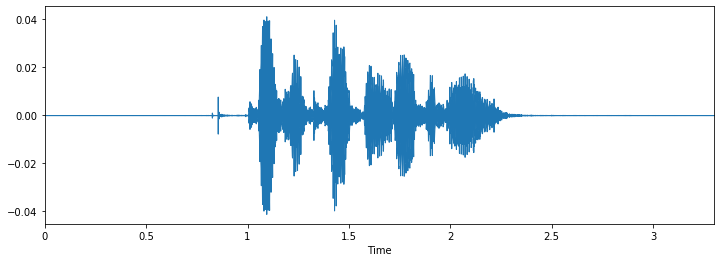

In [56]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data[:], sr=sample_rate)

## Preprocessing Audio Dataset

* Iterate through all files in audio, and give labels based on the file name. 

* Using Librosa feature extraction methods right now to get a feature vector, but could convert to a spectrogram and use a CNN if I have time. 

* **1440 audio samples total, all are audio and speech**

### Data into X, y format

In [ ]:
fn_list_i = [
 feature.chroma_stft,
 feature.spectral_centroid,
 feature.spectral_bandwidth,
 feature.spectral_rolloff
]
 
fn_list_ii = [
 feature.rms,
 feature.zero_crossing_rate
]

def parser(row):
    # function to load files and extract features
    file_name = os.path.join(os.path.abspath(data_dir), 'Train', str(row.ID) + '.wav')

    # handle exception to check if there isn't a file which is corrupted
    try:
        # here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # we extract mfcc feature from data
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    feature = mfccs
    label = row.Class

    return [feature, label]

'''
Function to normalize spectrogram
'''
def normalize_spectrogram(spectrogram): 
    return spectrogram 

'''
Get spectrogram for each audio file. 
'''
def get_spectrogram(y, sr):
    spectrogram = librosa.feature.melspectrogram(y, sr)
    return spectrogram

'''
Function to plot a spectrogram 
'''
def plot_spectrogram(spectrogram, y, sr, title='Mel-frequency spectrogram'):
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(spectrogram, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sample_rate,
                             fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=title)
    plt.show()
    
'''
Given the data and the sample rate, this function returns a
feature vector that can be inputted into the ML model. 
'''
def get_feature_vector(y, sr): 
    feat_vect_i = [ np.mean(funct(y,sr)) for funct in fn_list_i]
    feat_vect_ii = [ np.mean(funct(y)) for funct in fn_list_ii] 
    feature_vector = feat_vect_i + feat_vect_ii 
    return feature_vector

'''
Given the string `filename`, this function returns a list containing
labels for each class. 

The `filename` is always in the format '01-01-01-01-01-01-01.wav'
'''
def parse_filename(filename):
    filename = filename[:20]
    test_str = filename.split('-')
    
    test_int = [int(i) for i in test_str]
    return test_int

### Sample Spectrogram

In [169]:
data, sample_rate = librosa.load(data_file_name)
spectrogram = get_spectrogram(data, sample_rate)

In [171]:
print(spectrogram.shape)

(128, 143)


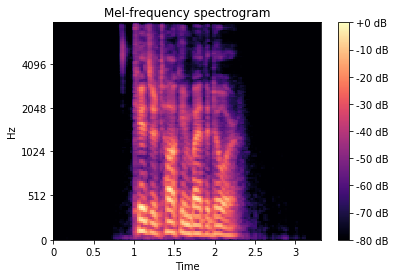

In [174]:
plot_spectrogram(spectrogram, data, sample_rate)
# todo: plot some random ones for each label as a sanity check

### Dataset Creation
* Minimum spectrogram length is 127

In [220]:
directory = r'C:/Users/ekin/Documents/jupyter_notebooks/iPresent/exp_notebooks/audio'

def create_datasets(directory):
    X = []
    y = []
    
    shown = {}
    for folder_name in tqdm(os.listdir(directory)): 
        folder_path = os.path.join(directory, folder_name)
    
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
#             print(len(file_name))
            
            # Get feature vector from .wav
            data, sample_rate = librosa.load(file_path)
#             feature_vector = get_feature_vector(data, sample_rate)
            spectrogram = get_spectrogram(data, sample_rate)
            spectrogram = center_crop(spectrogram, 124)
        
            # Get label vector for each class
            label_vector = parse_filename(file_name)
            emotion = label_vector[2]
            if emotion not in shown: 
                plot_spectrogram(spectrogram, data, sample_rate, title=str(emotion))
                shown[emotion] = 1
            
            # todo: Feature Engineering: combining emotion and emotional intensity
            y.append(emotion) # append only emotion for now
            X.append(spectrogram) # add to dset list

    X = np.array(X)
    y = np.array(y)
    return X, y     
            
def create_one_hot(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

'''
This function center crops each spectrogram numpy array given
a desired length. 
'''
def center_crop(spec, length):
    spec_size = spec.shape[-1]
    mid = spec_size // 2
    
    length_mid = length // 2
    start = mid - length_mid 
    end = mid + length_mid
    return spec[:, start:end]

'''
Crop all spectrograms in the dataset
'''
def crop_all_X(X, length=124):
    X_new = []
    for x in X: 
        x_new = center_crop(x, length)
        X_new.append(x_new)
    X_new = np.array(X_new)
    return X_new



  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

  4%|███▍                                                                               | 1/24 [00:09<03:43,  9.70s/it]

  8%|██████▉                                                                            | 2/24 [00:18<03:25,  9.36s/it]

 12%|██████████▍                                                                        | 3/24 [00:26<03:11,  9.10s/it]

 17%|█████████████▊                                                                     | 4/24 [00:34<02:56,  8.83s/it]

 21%|█████████████████▎                                                                 | 5/24 [00:43<02:45,  8.72s/it]

 25%|████████████████████▊                                                              | 6/24 [00:52<02:36,  8.70s/it]

 29%|████████████████████████▏                                                          | 7/24 [01:00<02:27,  8.68s/it]

 33%|█████████████████████████

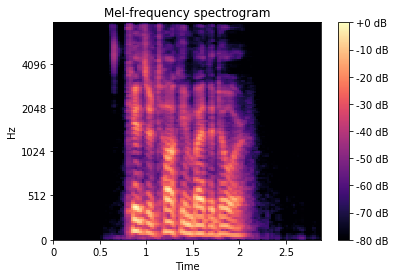

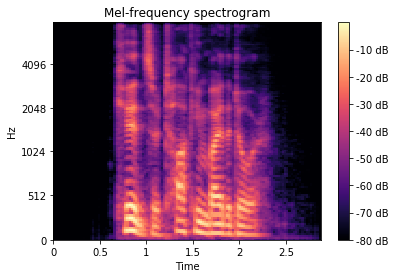

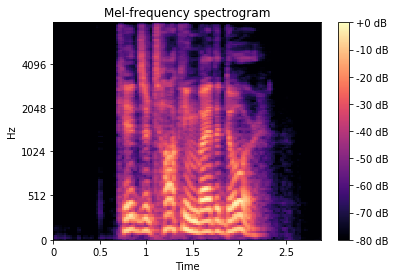

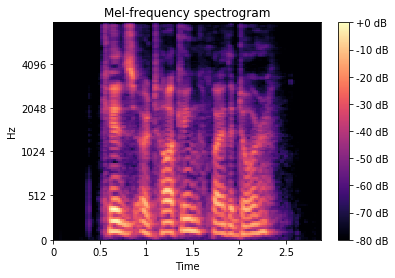

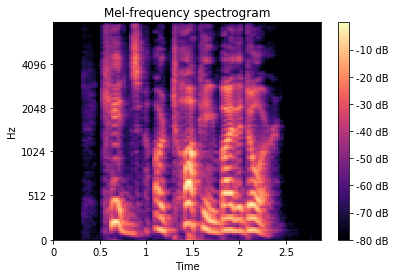

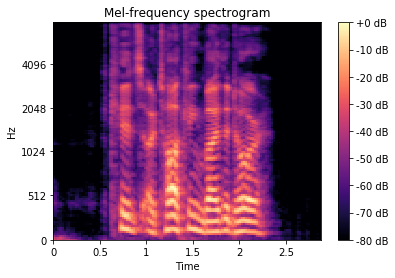

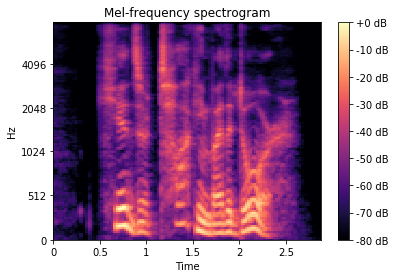

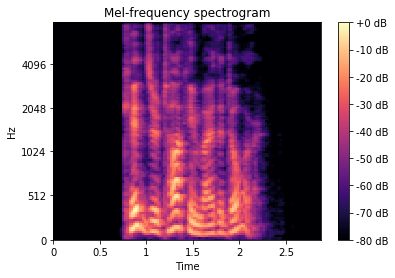

In [221]:
X, y = create_datasets(directory)

In [255]:
X = np.expand_dims(X, axis=-1)

In [256]:
print(X.shape)

(1440, 128, 124, 1)


In [225]:
y = create_one_hot(y)

In [226]:
y = [i[1:] for i in y]
y = np.array(y)

In [227]:
print('X shape: ', X.shape)
print('y shape: ', y.shape)

print(y[:10])

X shape:  (1440, 128, 124)
y shape:  (1440, 8)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


### Normalize Data

### Convert into TF Datasets

In [261]:
def split_dataset(X_dset, y_dset, val_size=0.15, test_size=0.15): 
    X_train, X_test, y_train, y_test = train_test_split(
        X_dset, y_dset, test_size=test_size, random_state=42
    )
    
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    
    print('X_test shape: ', X_test.shape)
    print('y_test shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test

def create_dsets(X_train, X_test, y_train, y_test, batch_size=16): 
    train_dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    test_dset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    return train_dset, test_dset

In [262]:
X_train, X_test, y_train, y_test = split_dataset(X, y)
train_dset, test_dset = create_dsets(X_train, X_test, y_train, y_test)

X_train shape:  (1224, 128, 124, 1)
y_train shape:  (1224, 8)
X_test shape:  (216, 128, 124, 1)
y_test shape:  (216, 8)


## Deep Learning Model

In [269]:
HIDDEN_UNITS = 128
EPOCHS = 10

In [272]:
def create_conv_model(input_shape=(128, 124, 1), num_classes=8):
    model = tf.keras.Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    #Compile
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

model = create_conv_model()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 127, 123, 32)      160       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 126, 122, 64)      8256      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 61, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 63, 61, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 245952)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               62963968  
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)             

In [271]:
def create_model(hidden_units): 
    model = tf.keras.Sequential()
    input_layer = tf.keras.layers.Input(shape=(6,))
    hidden_layer_1 = tf.keras.layers.Dense(hidden_units, activation='relu')
    hidden_layer_2 = tf.keras.layers.Dense(hidden_units, activation='relu')
    # hidden_layer_3 = tf.keras.layers.Dense(hidden_units/2, activation='relu')
    output_layer = tf.keras.layers.Dense(8, activation='softmax')
    model.add(input_layer)
    model.add(hidden_layer_1)
    model.add(hidden_layer_2)
    # model.add(hidden_layer_3)
    model.add(output_layer)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model

# model = create_model(HIDDEN_UNITS)

In [267]:
def plot(p1, p2=None, title='Plot', x_label='', y_label='', p1_legend=None, p2_legend=None): 
    plt.figure()
    plt.plot(range(len(p1)), p1, label=p1_legend)
    if p2 is not None: 
        plt.plot(range(len(p2)), p2, label=p2_legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()   

In [273]:
hist = model.fit(train_dset, validation_data=test_dset, epochs=EPOCHS)

Epoch 1/10
77/77 [==============================] - 34s 434ms/step - loss: 7.4036 - accuracy: 0.2370 - val_loss: 1.7680 - val_accuracy: 0.3565
Epoch 2/10
77/77 [==============================] - 33s 432ms/step - loss: 1.8097 - accuracy: 0.3139 - val_loss: 1.7079 - val_accuracy: 0.3380
Epoch 3/10
77/77 [==============================] - 33s 430ms/step - loss: 1.5242 - accuracy: 0.4665 - val_loss: 1.8925 - val_accuracy: 0.4213
Epoch 4/10
77/77 [==============================] - 33s 433ms/step - loss: 1.3732 - accuracy: 0.5363 - val_loss: 2.1420 - val_accuracy: 0.4537
Epoch 5/10
77/77 [==============================] - 33s 430ms/step - loss: 1.1911 - accuracy: 0.6121 - val_loss: 2.6892 - val_accuracy: 0.4213
Epoch 6/10
77/77 [==============================] - 33s 427ms/step - loss: 1.0177 - accuracy: 0.6825 - val_loss: 3.3458 - val_accuracy: 0.4306
Epoch 7/10
77/77 [==============================] - 33s 424ms/step - loss: 0.9824 - accuracy: 0.7150 - val_loss: 2.8019 - val_accuracy: 0.4259

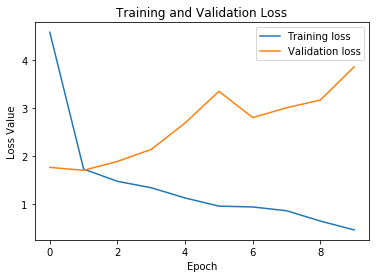

In [274]:
plot(hist.history['loss'], p2=hist.history['val_loss'], 
             title='Training and Validation Loss', x_label='Epoch', y_label='Loss Value', 
            p1_legend='Training loss', p2_legend='Validation loss')

In [275]:
y_pred = model.predict(train_dset)

In [276]:
def plot_probs(pred, true): 
    one_indices = []
    zero_indices = []
    for index, i in enumerate(true): 
        if i == 1: 
            one_indices.append(index)
        else: 
            zero_indices.append(index)
    plt.figure()
    plt.bar(zero_indices, pred[zero_indices], color='blue')
    plt.bar(one_indices, pred[one_indices], color='red')
    plt.plot()

C:\Users\ekin\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


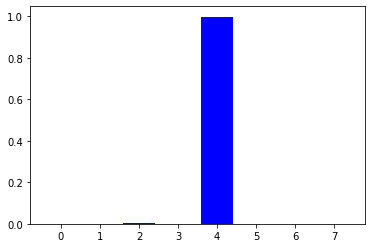

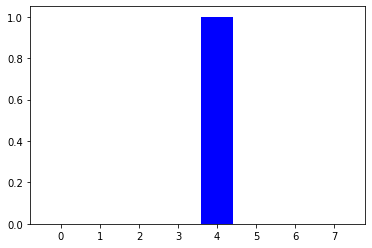

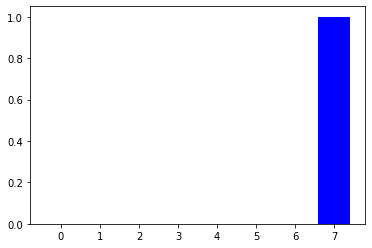

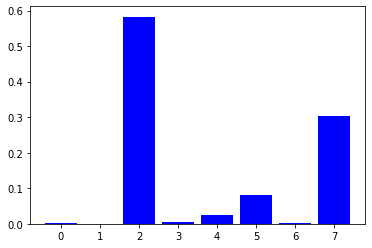

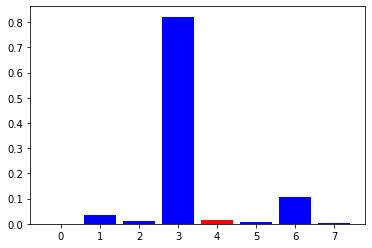

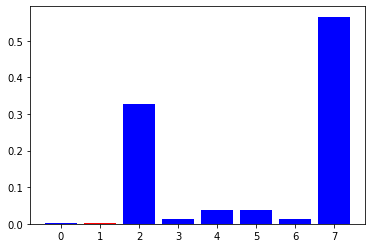

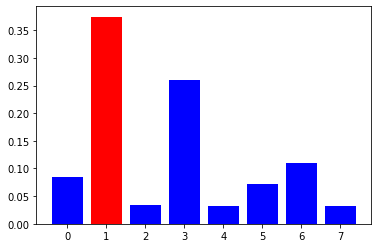

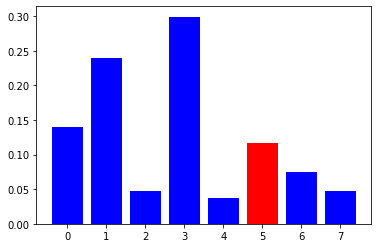

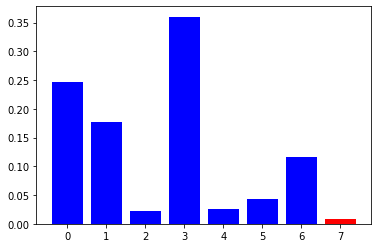

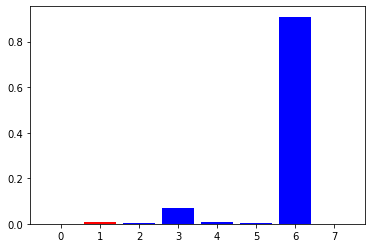

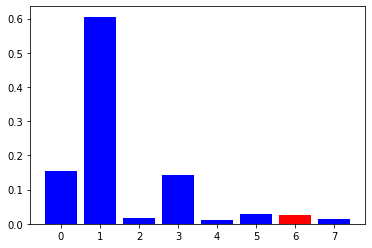

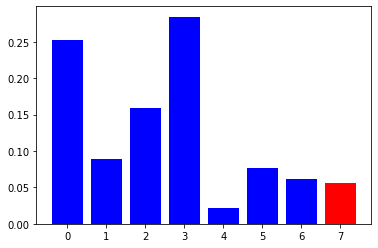

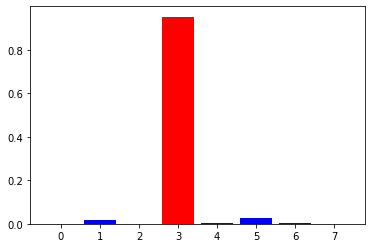

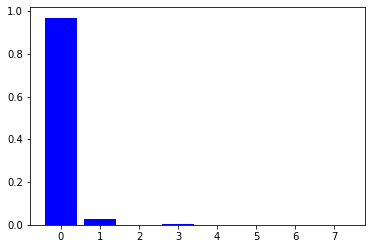

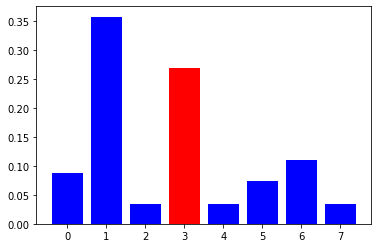

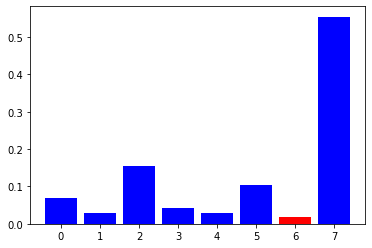

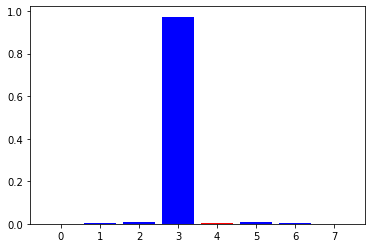

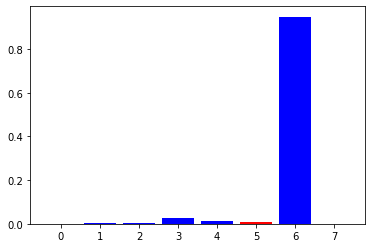

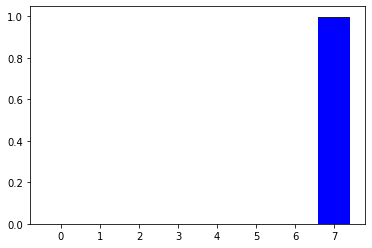

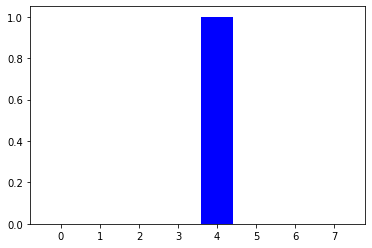

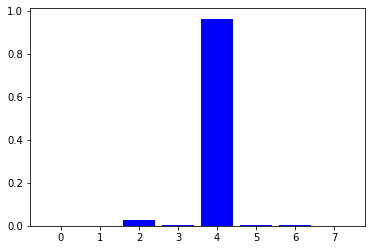

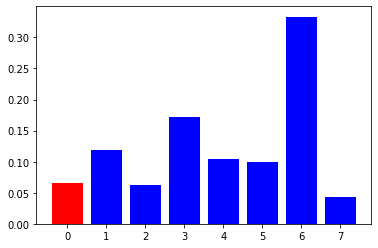

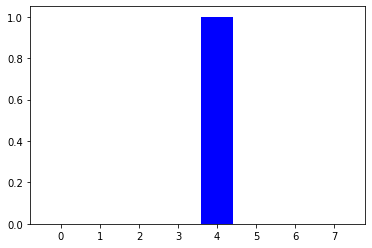

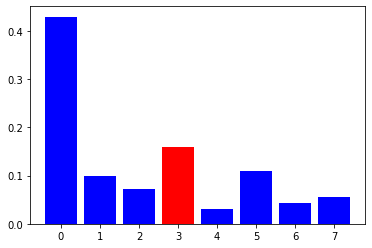

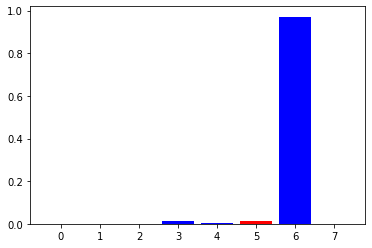

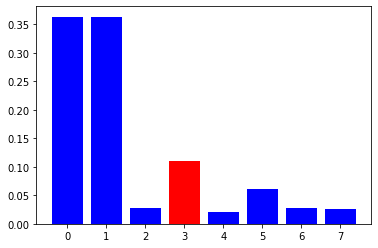

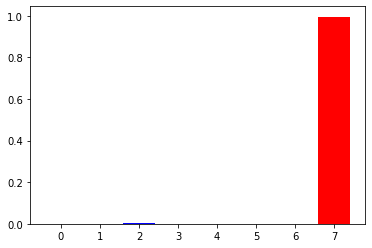

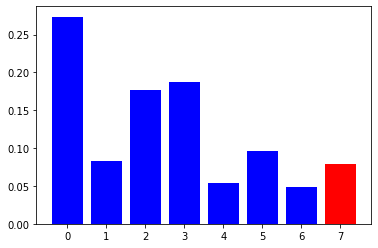

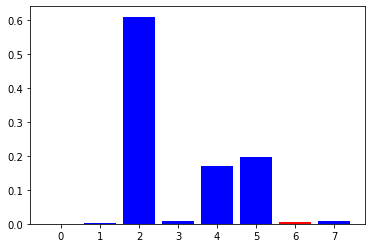

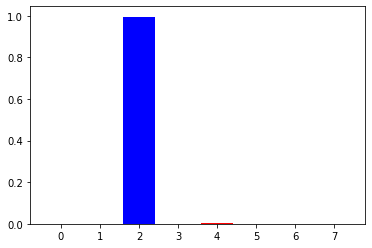

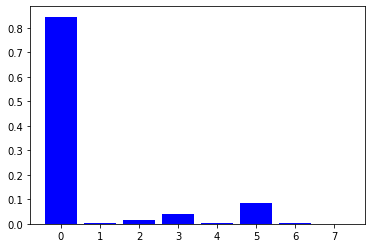

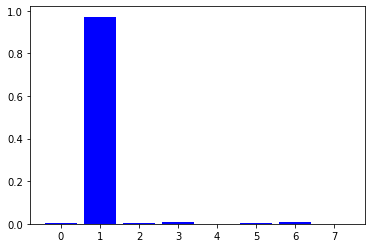

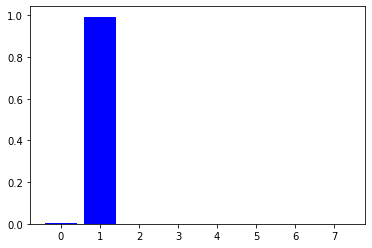

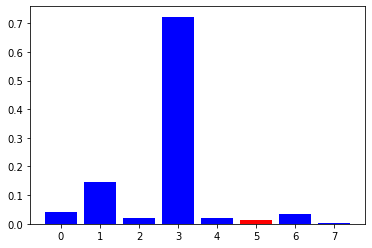

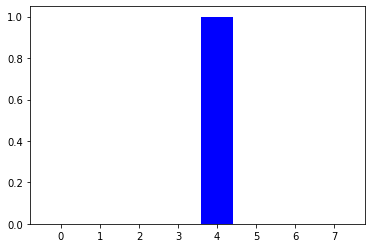

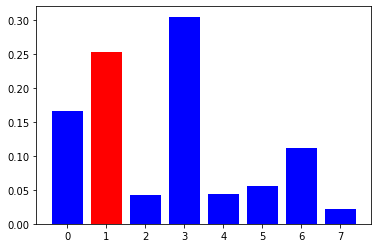

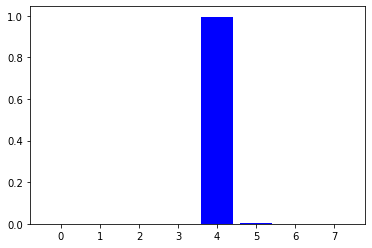

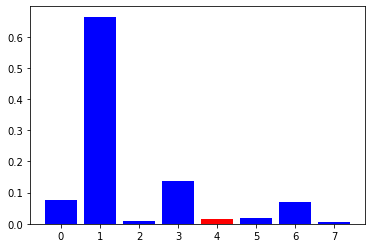

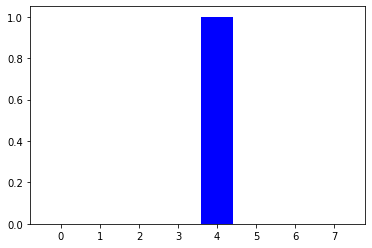

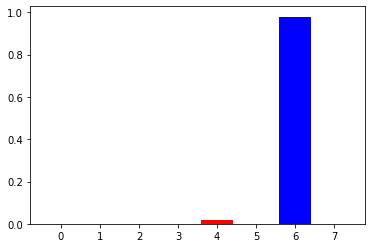

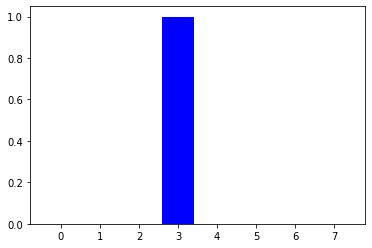

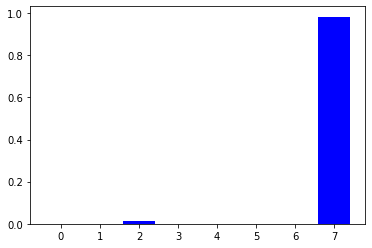

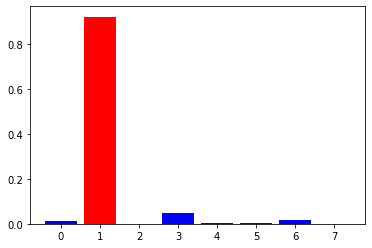

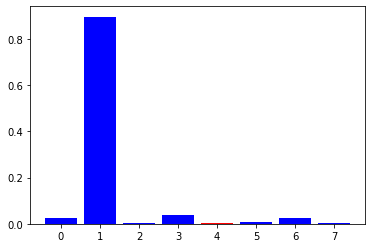

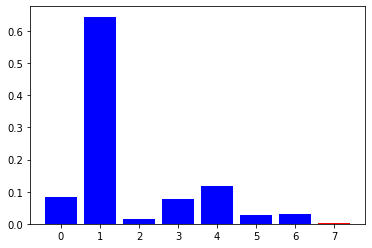

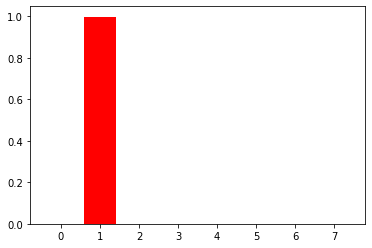

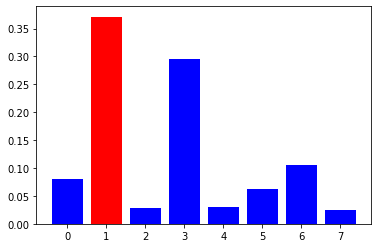

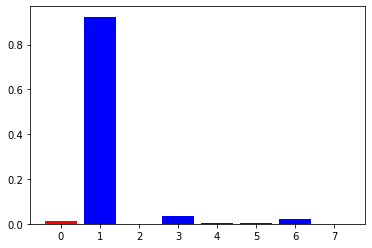

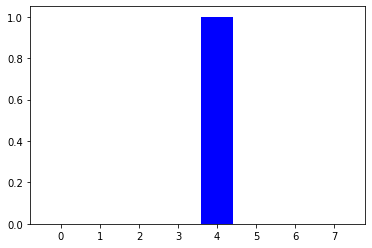

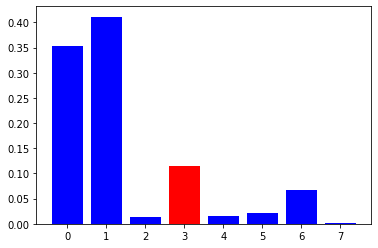

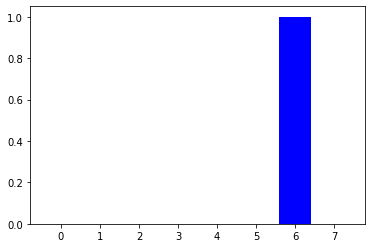

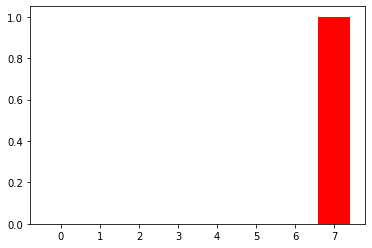

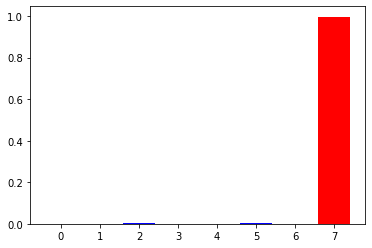

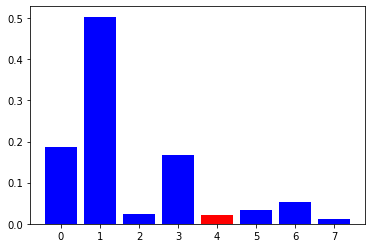

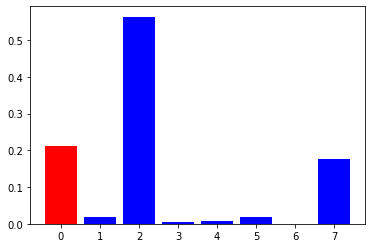

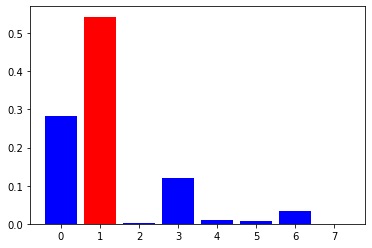

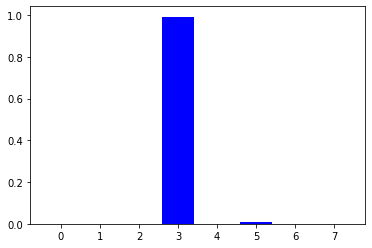

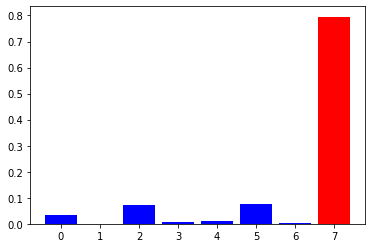

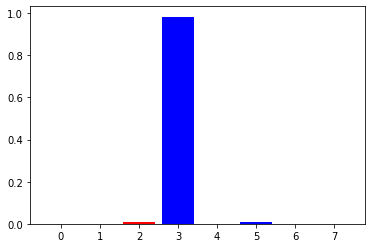

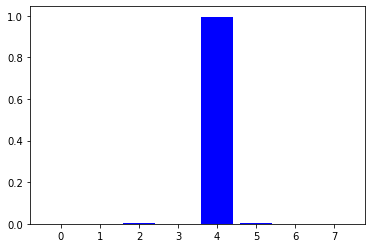

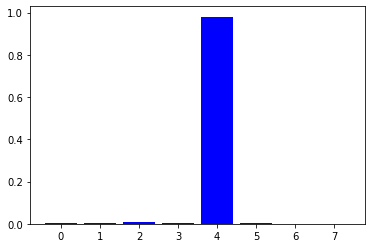

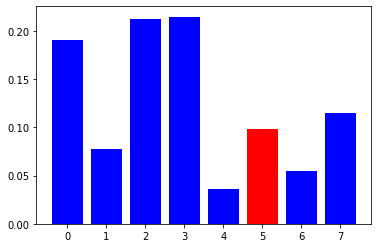

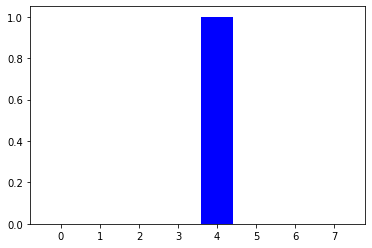

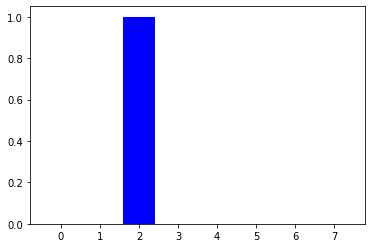

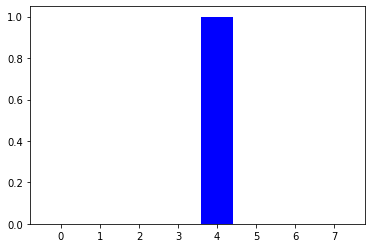

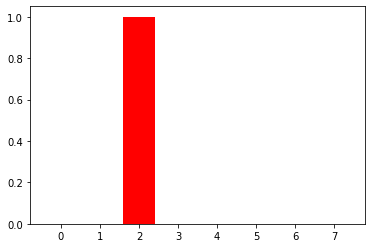

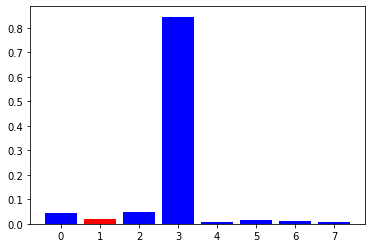

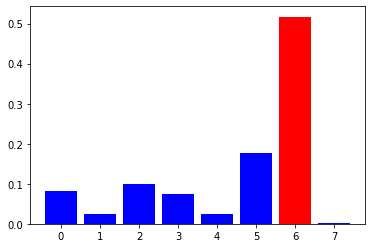

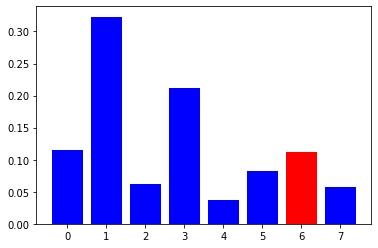

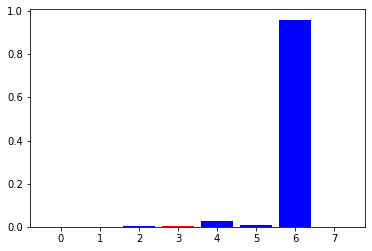

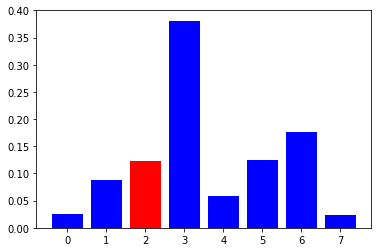

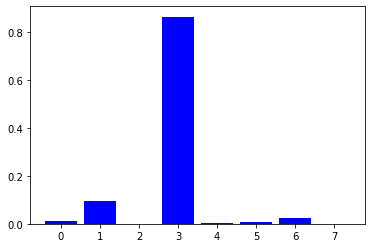

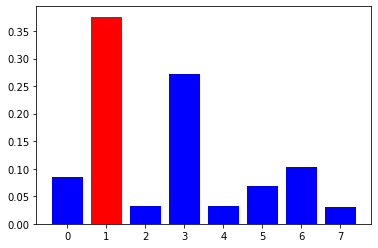

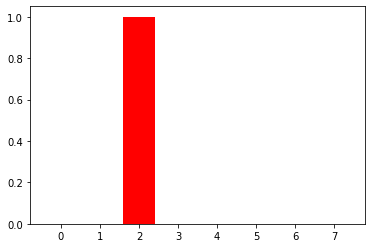

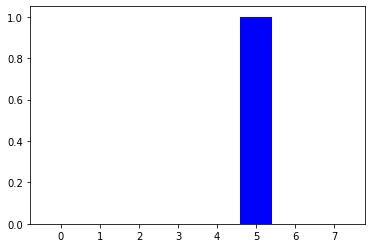

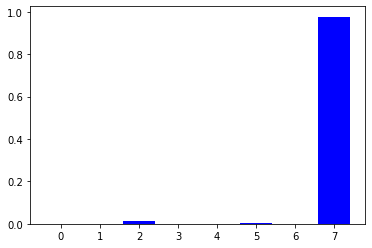

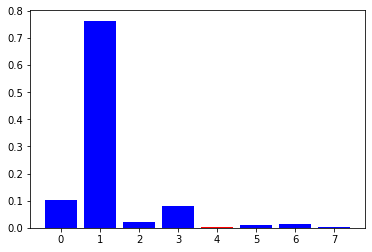

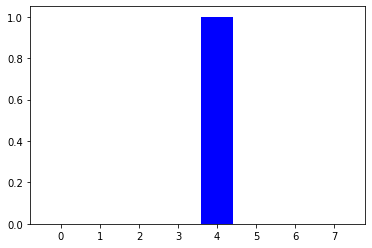

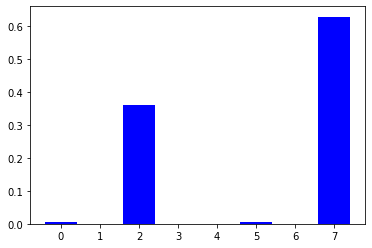

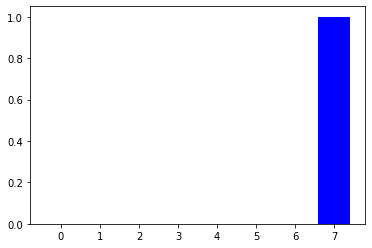

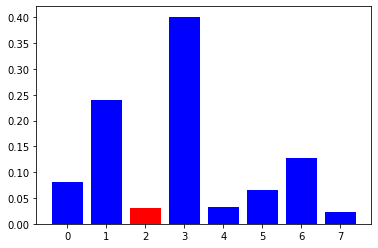

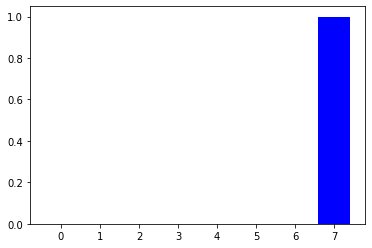

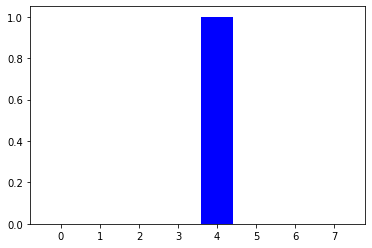

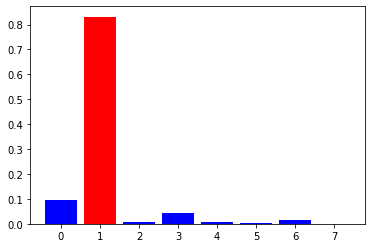

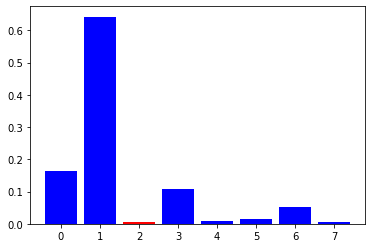

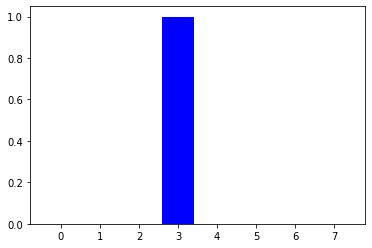

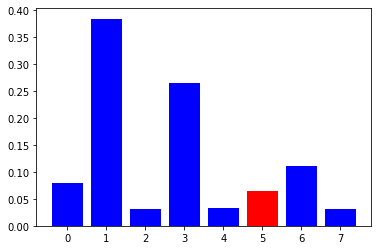

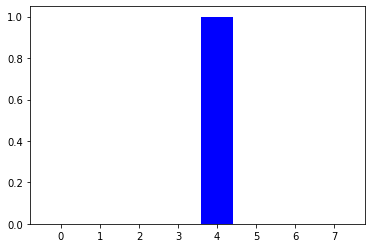

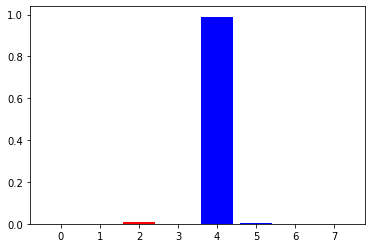

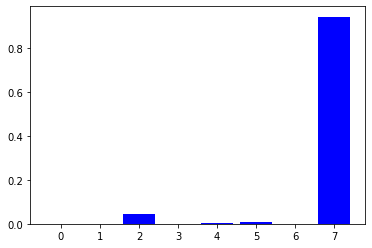

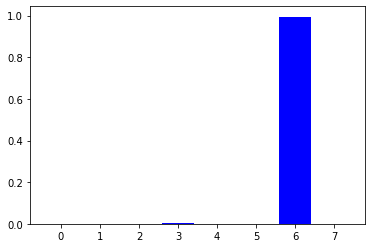

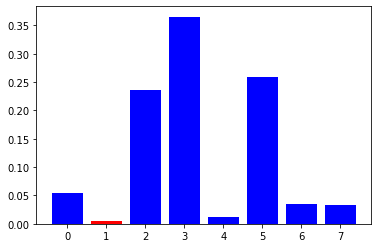

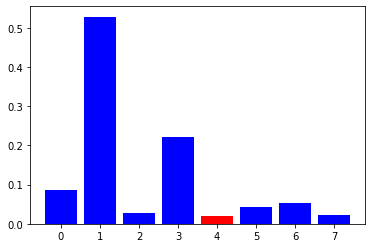

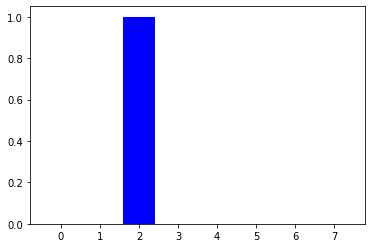

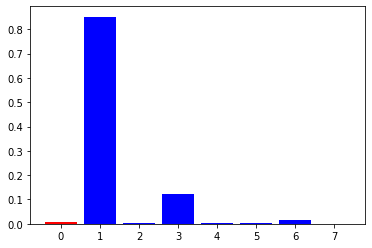

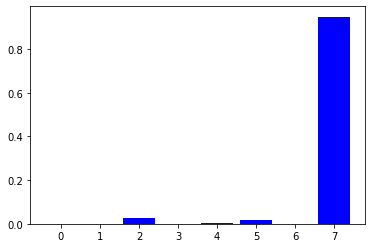

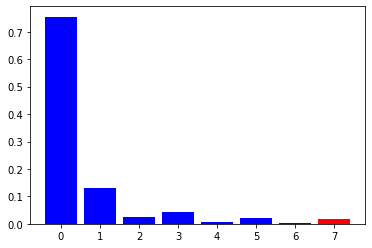

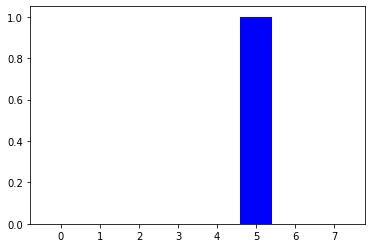

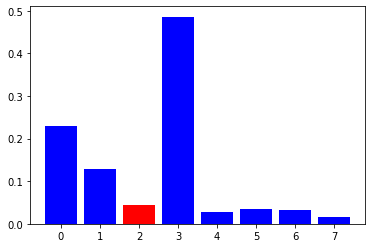

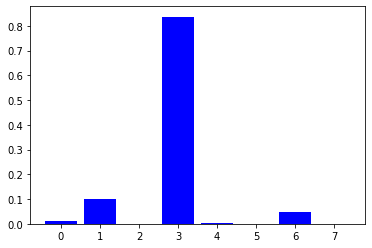

In [277]:
# Visualize random subset of transcripts performance
for i in range(0, 100): 
    plot_probs(y_pred[i], y_test[i])    